# ML Pipeline Demonstration

This notebook demonstrates how to use the ML Pipeline for LGBM classification. It covers the basic functionality of each component and shows how they work together.

In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import the ML pipeline
from ml_pipeline import DataLoader, DataProcessor, ML_Pipeline

# Set up paths
TRAIN_CONFIG_PATH = "data_config_train.json"
TEST_CONFIG_PATH = "data_config_test.json"
MODEL_CONFIG_PATH = "model_config.json"

# Create output directory if it doesn't exist
os.makedirs("trained_model_outputs_path", exist_ok=True)

## 1. Data Loader Demonstration

First, let's demonstrate the DataLoader class which handles loading and validating the data.

In [2]:
# Initialize the data loader with training configuration
data_loader = DataLoader(TRAIN_CONFIG_PATH, MODEL_CONFIG_PATH)

# Get configurations
data_config = data_loader.get_data_config()
model_config = data_loader.get_model_config()

print("Data config:")
for key, value in data_config.items():
    print(f"  {key}: {value}")

print("\nModel config:")
for key, value in model_config.items():
    if key != "hyperparameter_space":  # Skip printing hyperparameter space for brevity
        print(f"  {key}: {value}")

Data config:
  training: True
  metadata_file_path: feature_metadata.xlsx
  input_data_source: CSV
  file_path: example_inputs_v1.csv

Model config:
  target_variable: target
  id_variables: ['id_col', 'date_col']
  problem_type: classification
  evaluation_metric: rocauc
  better_performance: gt
  models: ['lgbm']
  k_folds: 5
  retrain_with_whole_dataset: True
  sample_for_contribution: 1.0
  importance_extraction_method: treeinterpreter
  num_hp_searches: 5


In [3]:
# Get feature metadata
feature_metadata = data_loader.get_feature_metadata()
print("Feature metadata summary:")
print(f"  Total features: {len(feature_metadata)}")
print("\nFeature metadata preview:")
display(feature_metadata.head())

Feature metadata summary:
  Total features: 17

Feature metadata preview:


,feature_name,type,use,imputation,transformation,super_category
0,id_col,category,0,unknown,None,1_id
1,date_col,category,0,unknown,None,1_id
2,target,bool,1,unknown,NaN,2_DEPENDENT
3,feature_0,float,1,mean,Standardize,3_features
4,feature_1,float,1,mean,Standardize,3_features


In [4]:
# Get the data with correct data types
data = data_loader.get_data()
print("Data summary:")
print(f"  Shape: {data.shape}")
print(f"  Columns: {list(data.columns)}")
print("\nData preview:")
display(data.head())

print("\nData types:")
display(data.dtypes)

Data summary:
  Shape: (1000, 17)
  Columns: ['id_col', 'date_col', 'target', 'feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13']

Data preview:


,id_col,date_col,target,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13
0,tMDgt,1/1/2025,True,0.049852,-0.089866,-1.737027,-0.563298,1.438655,0.423646,-0.571617,2.344470,0.329684,-1.687705,c,NaN,True,True
1,RgeWT,1/1/2025,True,0.600273,1.293923,-0.768878,-1.674227,0.656431,-0.030041,1.393623,-1.575807,1.485816,0.163634,b,NaN,True,False
2,BXjMC,1/1/2025,False,-2.998233,0.631200,1.180551,0.640171,-1.244864,-0.020427,0.127345,1.303097,-1.408630,-1.171414,b,e,False,False
3,hwtkX,1/1/2025,True,2.641943,0.117200,-1.211940,-0.171758,0.657611,-1.026694,0.446694,-1.116131,3.546071,0.043762,b,d,True,True
4,nJfRw,1/1/2025,False,-3.386397,1.547925,0.356687,0.930875,-0.673196,0.976374,0.154054,1.594067,-1.075212,-0.985810,c,e,False,True



Data types:


id_col        category
date_col      category
target            bool
feature_0      float64
feature_1      float64
feature_2      float64
feature_3      float64
feature_4      float64
feature_5      float64
feature_6      float64
feature_7      float64
feature_8      float64
feature_9      float64
feature_10    category
feature_11    category
feature_12        bool
feature_13        bool
dtype: object

## 2. Data Processor Demonstration

Next, let's demonstrate the DataProcessor class which handles preprocessing the data.

In [5]:
# Initialize the data processor
data_processor = DataProcessor(
    feature_metadata=feature_metadata,
    model_config=model_config,
    output_dir="trained_model_outputs_path"
)

# Print feature categorization
print("Feature categorization:")
print(f"  Numerical features: {data_processor.numerical_features}")
print(f"  Categorical features: {data_processor.categorical_features}")
print(f"  Binary features: {data_processor.binary_features}")
print(f"  One-hot features: {data_processor.one_hot_features}")
print(f"  Leave as NA features: {data_processor.leave_as_na_features}")

Feature categorization:
  Numerical features: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9']
  Categorical features: ['feature_11']
  Binary features: ['feature_12', 'feature_13']
  One-hot features: ['feature_10']
  Leave as NA features: ['feature_9', 'feature_11', 'feature_13']


Created 5 folds for cross-validation


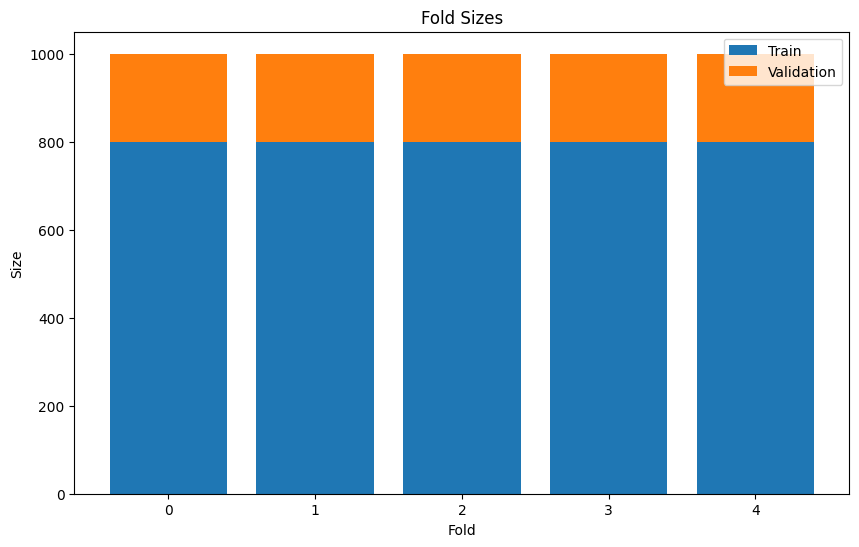

In [6]:
# Create folds for cross-validation
fold_indices = data_processor.create_folds(data)
print(f"Created {len(fold_indices)} folds for cross-validation")

# Visualize the fold sizes
fold_sizes = [(fold[0].shape[0], fold[1].shape[0]) for fold in fold_indices]
df_fold_sizes = pd.DataFrame(fold_sizes, columns=['train_size', 'val_size'])
df_fold_sizes['fold'] = range(len(fold_indices))

plt.figure(figsize=(10, 6))
plt.bar(df_fold_sizes['fold'], df_fold_sizes['train_size'], label='Train')
plt.bar(df_fold_sizes['fold'], df_fold_sizes['val_size'], bottom=df_fold_sizes['train_size'], label='Validation')
plt.xlabel('Fold')
plt.ylabel('Size')
plt.title('Fold Sizes')
plt.legend()
plt.show()

In [7]:
# Preprocess the training data
preprocessed_data = data_processor.preprocess_training_data(data, fold_indices)
print("Preprocessed data:")
print(f"  Original data shape: {preprocessed_data['original_data'].shape}")
print(f"  Features shape: {preprocessed_data['X'].shape}")
print(f"  Target shape: {preprocessed_data['y'].shape}")
print(f"  Number of folds: {len(preprocessed_data['folds'])}")

# Print info for the first fold
first_fold = preprocessed_data['folds'][0]
print("\nFirst fold:")
print(f"  Fold index: {first_fold['fold_idx']}")
print(f"  Training indices shape: {first_fold['train_idx'].shape}")
print(f"  Validation indices shape: {first_fold['val_idx'].shape}")
print(f"  X_train shape: {first_fold['X_train'].shape}")
print(f"  X_train_transformed shape: {first_fold['X_train_transformed'].shape}")
print(f"  X_val shape: {first_fold['X_val'].shape}")
print(f"  X_val_transformed shape: {first_fold['X_val_transformed'].shape}")

Preprocessed data:
  Original data shape: (1000, 17)
  Features shape: (1000, 14)
  Target shape: (1000,)
  Number of folds: 5

First fold:
  Fold index: 0
  Training indices shape: (800,)
  Validation indices shape: (200,)
  X_train shape: (800, 14)
  X_train_transformed shape: (800, 16)
  X_val shape: (200, 14)
  X_val_transformed shape: (200, 16)


/Users/jonathanbugg/Desktop/ml_pipeline_second_try/bnbj_ml_pipeline/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/jonathanbugg/Desktop/ml_pipeline_second_try/bnbj_ml_pipeline/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/jonathanbugg/Desktop/ml_pipeline_second_try/bnbj_ml_pipeline/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/

In [8]:
first_fold.keys()

dict_keys(['fold_idx', 'train_idx', 'val_idx', 'X_train', 'y_train', 'X_val', 'y_val', 'X_train_transformed', 'X_val_transformed', 'preprocessor'])

In [9]:
first_fold['X_train']

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13
0,0.049852,-0.089866,-1.737027,-0.563298,1.438655,0.423646,-0.571617,2.344470,0.329684,-1.687705,c,NaN,1.0,1.0
2,-2.998233,0.631200,1.180551,0.640171,-1.244864,-0.020427,0.127345,1.303097,-1.408630,-1.171414,b,e,0.0,0.0
4,-3.386397,1.547925,0.356687,0.930875,-0.673196,0.976374,0.154054,1.594067,-1.075212,-0.985810,c,e,0.0,1.0
5,2.126995,-1.517127,-2.342107,-1.355205,2.967729,0.052961,-0.483681,1.540000,-1.227536,0.586650,b,NaN,0.0,0.0
7,-2.601452,2.137424,0.734522,-2.426318,-1.236647,-0.155181,0.272949,-0.368024,0.032454,-0.068216,c,d,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,-1.362858,0.515230,0.575891,0.357162,-1.126756,0.628330,-2.275661,0.732208,-0.831174,-0.674814,a,f,1.0,0.0
993,1.098945,-0.473857,-2.105712,-0.474053,2.752221,-1.962530,-0.310727,0.854747,-1.929254,0.505420,b,d,1.0,1.0
996,-0.886578,-0.597894,2.781754,0.463224,-2.993203,0.953035,0.057709,-0.809979,0.718821,-0.387151,a,d,1.0,1.0
997,-4.827319,2.097245,0.457689,-0.497374,-1.028710,0.756048,-1.437772,2.531967,-2.451756,1.093313,c,d,1.0,1.0


In [10]:
first_fold['X_train_transformed']

,num__feature_0,num__feature_1,num__feature_2,num__feature_3,num__feature_4,num__feature_5,num__feature_6,num__feature_7,num__feature_8,onehot__feature_10_a,onehot__feature_10_b,onehot__feature_10_c,bin__feature_12,remainder__feature_9,remainder__feature_11,remainder__feature_13
0,0.017816,-0.335889,-0.621129,-0.476006,0.536140,0.408396,0.005239,1.260329,0.203317,0.0,0.0,1.0,1.0,-1.687705,NaN,1.0
2,-1.186431,0.130214,1.261022,0.695829,-1.137989,-0.042611,0.457958,0.583804,-0.839158,0.0,1.0,0.0,0.0,-1.171414,e,0.0
4,-1.339788,0.722793,0.729541,0.978891,-0.781350,0.969755,0.475258,0.772832,-0.639206,0.0,0.0,1.0,0.0,-0.985810,e,1.0
5,0.838459,-1.258482,-1.011471,-1.247098,1.490062,0.031923,0.062195,0.737707,-0.730555,0.0,1.0,0.0,0.0,0.586650,NaN,0.0
7,-1.029669,1.103849,0.973286,-2.290056,-1.132863,-0.179469,0.552267,-0.501835,0.025067,0.0,0.0,1.0,0.0,-0.068216,d,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,-0.540322,0.055250,0.870952,0.420259,-1.064306,0.616276,-1.098474,0.212928,-0.492855,1.0,0.0,0.0,1.0,-0.674814,f,0.0
993,0.432294,-0.584104,-0.858971,-0.389107,1.355616,-2.015042,0.174218,0.292535,-1.151379,0.0,1.0,0.0,1.0,0.505420,d,1.0
996,-0.352152,-0.664283,2.293970,0.523534,-2.228700,0.946052,0.412855,-0.788949,0.436685,1.0,0.0,0.0,1.0,-0.387151,d,1.0
997,-1.909071,1.077877,0.794699,-0.411815,-1.003140,0.745988,-0.555771,1.382136,-1.464726,0.0,0.0,1.0,1.0,1.093313,d,1.0


In [11]:
# Fit and transform the full dataset
X_transformed, y = data_processor.fit_transform_full_dataset(data)
print("Full dataset transformation:")
print(f"  X_transformed shape: {X_transformed.shape}")
print(f"  y shape: {y.shape}")

# Save the preprocessor
preprocessor_path = data_processor.save_preprocessor()
print(f"Preprocessor saved to: {preprocessor_path}")

Full dataset transformation:
  X_transformed shape: (1000, 16)
  y shape: (1000,)
Preprocessor saved to: trained_model_outputs_path/target_classification_lgbm_data_processor.pkl


/Users/jonathanbugg/Desktop/ml_pipeline_second_try/bnbj_ml_pipeline/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Manual testing that transformed data can be used to train LGBM

In [12]:
# import lightgbm as lgbm

# params = {
#      "boosting_type": "gbdt",
#      "learning_rate": 0.1,
#      "num_leaves": 31,
#      "feature_fraction": 0.8,
#      "n_estimators": 100
# }

# train_data = lgbm.Dataset(first_fold['X_train_transformed'], label=first_fold['y_train'])

# lgbm.train(
# train_set = train_data,
# params = params
# )

## 3. ML Pipeline Demonstration

Finally, let's demonstrate the full ML_Pipeline class which integrates data loading, preprocessing, and model training.

In [13]:
# Initialize the ML pipeline for training
pipeline = ML_Pipeline(MODEL_CONFIG_PATH, TRAIN_CONFIG_PATH)
print(f"ML Pipeline initialized for {'training' if pipeline.is_training else 'testing'}")

# Run the pipeline for training
pipeline.run()

ML Pipeline initialized for training
Starting training pipeline...


/Users/jonathanbugg/Desktop/ml_pipeline_second_try/bnbj_ml_pipeline/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/jonathanbugg/Desktop/ml_pipeline_second_try/bnbj_ml_pipeline/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/jonathanbugg/Desktop/ml_pipeline_second_try/bnbj_ml_pipeline/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/

Training lgbm models for classification problem...
Training fold 1/5...
Starting hyperparameter tuning with Optuna...


<string>:1: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
<string>:1: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
<string>:1: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
[I 2025-04-04 18:51:59,326] Trial 0 finished with value: 0.9551282051282051 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.15302307985954763, 'num_leaves': 76.0, 'feature_fraction': 0.2866324379761574, 'reg_lambda': 0.0591619464191165, 'n_estimators': 179.0, 'class_weight': None, 'min_data_in_leaf': 10.0}. Best is trial 0 with value: 0.955128205

Number of finished trials: 5
Best trial: 0
Best rocauc: 0.9551282051282051
Best hyperparameters:
  boosting_type: gbdt
  learning_rate: 0.15302307985954763
  num_leaves: 76.0
  feature_fraction: 0.2866324379761574
  reg_lambda: 0.0591619464191165
  n_estimators: 179.0
  class_weight: None
  min_data_in_leaf: 10.0
Training model with best hyperparameters...
Training until validation scores don't improve for 50 rounds


[I 2025-04-04 18:51:59,891] A new study created in memory with name: no-name-fdc74585-c808-46b2-ab93-04d9ce92b1e6
<string>:1: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
<string>:1: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
<string>:1: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
[I 2025-04-04 18:51:59,902] Trial 0 finished with value: 0.5 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.016572066927606408, 'num_leaves': 129.0, 'feature_fraction': 0.7995646061863775, 'reg_lambda': 0.07783450655369623, 'n_estima

Early stopping, best iteration is:
[49]	training's auc: 1	valid_1's auc: 0.955128
Training rocauc: 1.0
Validation rocauc: 0.9551282051282051
Fold 1 performance: 0.9551282051282051
Training fold 2/5...
Starting hyperparameter tuning with Optuna...


<string>:1: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
<string>:1: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
<string>:1: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
[I 2025-04-04 18:52:00,666] Trial 2 finished with value: 0.9824719551282052 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.02814606697075751, 'num_leaves': 130.0, 'feature_fraction': 0.9694973641726362, 'reg_lambda': 0.09080198055867478, 'n_estimators': 184.0, 'class_weight': 'balanced', 'min_data_in_leaf': 10.0}. Best is trial 2 with value: 0.9

Number of finished trials: 5
Best trial: 2
Best rocauc: 0.9824719551282052
Best hyperparameters:
  boosting_type: gbdt
  learning_rate: 0.02814606697075751
  num_leaves: 130.0
  feature_fraction: 0.9694973641726362
  reg_lambda: 0.09080198055867478
  n_estimators: 184.0
  class_weight: balanced
  min_data_in_leaf: 10.0
Training model with best hyperparameters...
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.999925	valid_1's auc: 0.979367


[I 2025-04-04 18:52:01,391] A new study created in memory with name: no-name-ed2074f6-4a80-47dc-b035-0f93bcdb0879
<string>:1: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
<string>:1: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
<string>:1: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
[I 2025-04-04 18:52:01,446] Trial 0 finished with value: 0.8804086538461539 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.028705607025966594, 'num_leaves': 49.0, 'feature_fraction': 0.9286486633734569, 'reg_lambda': 0.02574288091030

Did not meet early stopping. Best iteration is:
[178]	training's auc: 1	valid_1's auc: 0.982472
Training rocauc: 1.0
Validation rocauc: 0.9824719551282052
Fold 2 performance: 0.9824719551282052
Training fold 3/5...
Starting hyperparameter tuning with Optuna...
Number of finished trials: 5
Best trial: 2
Best rocauc: 0.9224258814102565
Best hyperparameters:
  boosting_type: gbdt
  learning_rate: 0.020554156830102473
  num_leaves: 75.0
  feature_fraction: 0.8723950506274643
  reg_lambda: 0.06110910396002375
  n_estimators: 197.0
  class_weight: None
  min_data_in_leaf: 140.0
Training model with best hyperparameters...
Training until validation scores don't improve for 50 rounds


[I 2025-04-04 18:52:01,656] A new study created in memory with name: no-name-f51a731d-54fb-4ee7-bb74-ade9b9006215
<string>:1: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
<string>:1: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
<string>:1: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.


[100]	training's auc: 0.96752	valid_1's auc: 0.919872
Early stopping, best iteration is:
[112]	training's auc: 0.970487	valid_1's auc: 0.922426
Training rocauc: 0.9704866218119231
Validation rocauc: 0.9224258814102565
Fold 3 performance: 0.9224258814102565
Training fold 4/5...
Starting hyperparameter tuning with Optuna...


[I 2025-04-04 18:52:01,906] Trial 0 finished with value: 0.9698517628205128 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.01743800810684508, 'num_leaves': 150.0, 'feature_fraction': 0.4676547829134031, 'reg_lambda': 0.036875290565843356, 'n_estimators': 171.0, 'class_weight': 'balanced', 'min_data_in_leaf': 35.0}. Best is trial 0 with value: 0.9698517628205128.
<string>:1: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
<string>:1: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
<string>:1: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugge

Number of finished trials: 5
Best trial: 0
Best rocauc: 0.9698517628205128
Best hyperparameters:
  boosting_type: gbdt
  learning_rate: 0.01743800810684508
  num_leaves: 150.0
  feature_fraction: 0.4676547829134031
  reg_lambda: 0.036875290565843356
  n_estimators: 171.0
  class_weight: balanced
  min_data_in_leaf: 35.0
Training model with best hyperparameters...
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.988284	valid_1's auc: 0.964944


[I 2025-04-04 18:52:02,306] A new study created in memory with name: no-name-3fc5ca5c-b83c-438d-8dfd-e6992b55726d
<string>:1: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
<string>:1: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
<string>:1: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
[I 2025-04-04 18:52:02,376] Trial 0 finished with value: 0.9452006806125514 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.01307285508750205, 'num_leaves': 37.0, 'feature_fraction': 0.9179344042147295, 'reg_lambda': 0.018417740113650

Did not meet early stopping. Best iteration is:
[170]	training's auc: 0.993278	valid_1's auc: 0.969852
Training rocauc: 0.993278047253951
Validation rocauc: 0.9698517628205128
Fold 4 performance: 0.9698517628205128
Training fold 5/5...
Starting hyperparameter tuning with Optuna...


<string>:1: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
<string>:1: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
<string>:1: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
[I 2025-04-04 18:52:02,531] Trial 3 finished with value: 0.9786808127314583 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.11335993079876423, 'num_leaves': 84.0, 'feature_fraction': 0.8426378615574668, 'reg_lambda': 0.08133336144947662, 'n_estimators': 134.0, 'class_weight': None, 'min_data_in_leaf': 120.0}. Best is trial 3 with value: 0.9786808

Number of finished trials: 5
Best trial: 4
Best rocauc: 0.9803823441096987
Best hyperparameters:
  boosting_type: gbdt
  learning_rate: 0.05778486631534851
  num_leaves: 138.0
  feature_fraction: 0.8312728136490274
  reg_lambda: 0.014457341152487114
  n_estimators: 140.0
  class_weight: None
  min_data_in_leaf: 75.0
Training model with best hyperparameters...
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.990942	valid_1's auc: 0.97798
Did not meet early stopping. Best iteration is:
[139]	training's auc: 0.995512	valid_1's auc: 0.980382
Training rocauc: 0.9955115685096154
Validation rocauc: 0.9803823441096987
Fold 5 performance: 0.9803823441096987
Retraining on full dataset...
DEBUGGING in ml_pipeline.py --------------------------
<class 'pandas.core.frame.DataFrame'>
   num__feature_0  num__feature_1  num__feature_2  num__feature_3  \
0        0.022284       -0.349856       -0.601730       -0.473799   
1        0.238350        0.558771        0.020

/Users/jonathanbugg/Desktop/ml_pipeline_second_try/bnbj_ml_pipeline/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Training rocauc: 0.997372205464691
Validation rocauc: 0.9803823441096987
Model saved to trained_model_outputs_path/target_classification_lgbm.pkl
Model saved to trained_model_outputs_path/target_classification_lgbm.pkl
Hyperparameter study results saved to trained_model_outputs_path/target_classification_lgbm_hyperparameter_study.csv
Hyperparameter study results saved to trained_model_outputs_path/target_classification_lgbm_hyperparameter_study.csv
Full dataset retraining completed.
Calculating feature importance...
Using all 1000 samples for feature importance calculation
Calculating treeinterpreter feature importance...
Converting LightGBM Booster to sklearn-compatible model for treeinterpreter...
Successfully converted LightGBM model to sklearn-compatible model
Error calculating treeinterpreter importance: 'LGBMClassifier' object has no attribute 'n_outputs_'
Falling back to SHAP for feature importance...
Calculating SHAP feature importance...
Feature importance results saved to tra

/Users/jonathanbugg/Desktop/ml_pipeline_second_try/bnbj_ml_pipeline/.venv/lib/python3.10/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Model performances:
  Fold 0: 0.9551282051282051
  Fold 1: 0.9824719551282052
  Fold 2: 0.9224258814102565
  Fold 3: 0.9698517628205128
  Fold 4: 0.9803823441096987


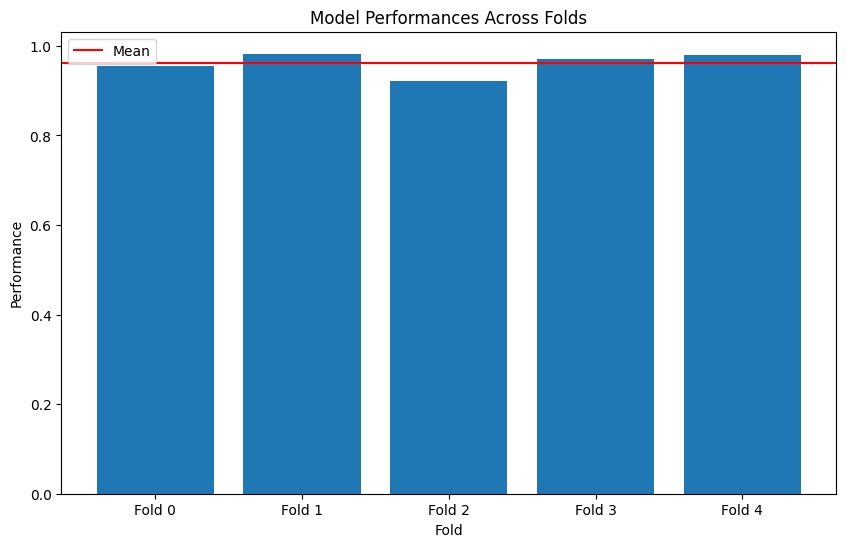

In [14]:
# Check the model performances
performances = pipeline.get_model_performances()
print("Model performances:")
for perf in performances:
    print(f"  Fold {perf['fold_idx']}: {perf['performance']}")

# Visualize the performances
plt.figure(figsize=(10, 6))
plt.bar(range(len(performances)), [p['performance'] for p in performances])
plt.axhline(y=np.mean([p['performance'] for p in performances]), color='r', linestyle='-', label='Mean')
plt.xlabel('Fold')
plt.ylabel('Performance')
plt.title('Model Performances Across Folds')
plt.xticks(range(len(performances)), [f"Fold {p['fold_idx']}" for p in performances])
plt.legend()
plt.show()

In [15]:
# Now initialize the ML pipeline for testing
test_pipeline = ML_Pipeline(MODEL_CONFIG_PATH, TEST_CONFIG_PATH)
print(f"ML Pipeline initialized for {'training' if test_pipeline.is_training else 'testing'}")

# Run the pipeline for testing
test_pipeline.run()

ML Pipeline initialized for testing
Starting testing pipeline...
Model loaded from trained_model_outputs_path/target_classification_lgbm.pkl
Predictions saved to trained_model_outputs_path/classification_v1.csv
Testing pipeline completed.


Predictions:
  Shape: (500, 3)
  Columns: ['prediction', 'id_col', 'date_col']


,prediction,id_col,date_col
0,0.006663,ofsGS,1/1/2025
1,0.992600,qqIVy,1/1/2025
2,0.018436,qfBQR,1/1/2025
3,0.017959,nYXTV,1/1/2025
4,0.004058,QirOv,1/1/2025


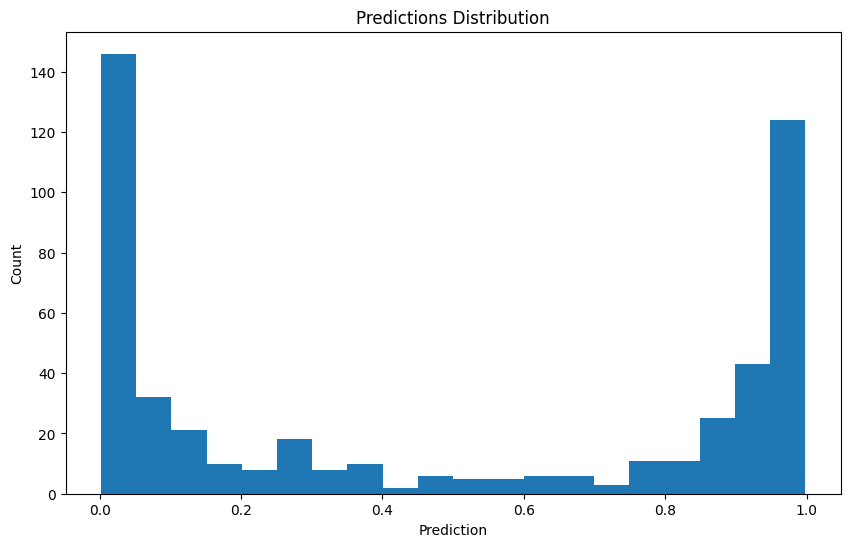

In [16]:
# Load and display the predictions
predictions_path = test_pipeline.data_config.get("predictions_output_path", "")
if os.path.exists(predictions_path):
    predictions_df = pd.read_csv(predictions_path)
    print("Predictions:")
    print(f"  Shape: {predictions_df.shape}")
    print(f"  Columns: {list(predictions_df.columns)}")
    display(predictions_df.head())
    
    # Visualize the predictions distribution
    plt.figure(figsize=(10, 6))
    plt.hist(predictions_df['prediction'], bins=20)
    plt.xlabel('Prediction')
    plt.ylabel('Count')
    plt.title('Predictions Distribution')
    plt.show()
else:
    print(f"Predictions file not found at: {predictions_path}")

## 4. Optional: Feature Importance Analysis

If desired, we can analyze the feature importances from the trained LGBM model.

Feature importances:


,feature_idx,importance
7,7,199
6,6,194
1,1,189
8,8,157
0,0,144
2,2,122
4,4,120
3,3,60
5,5,56
13,13,40


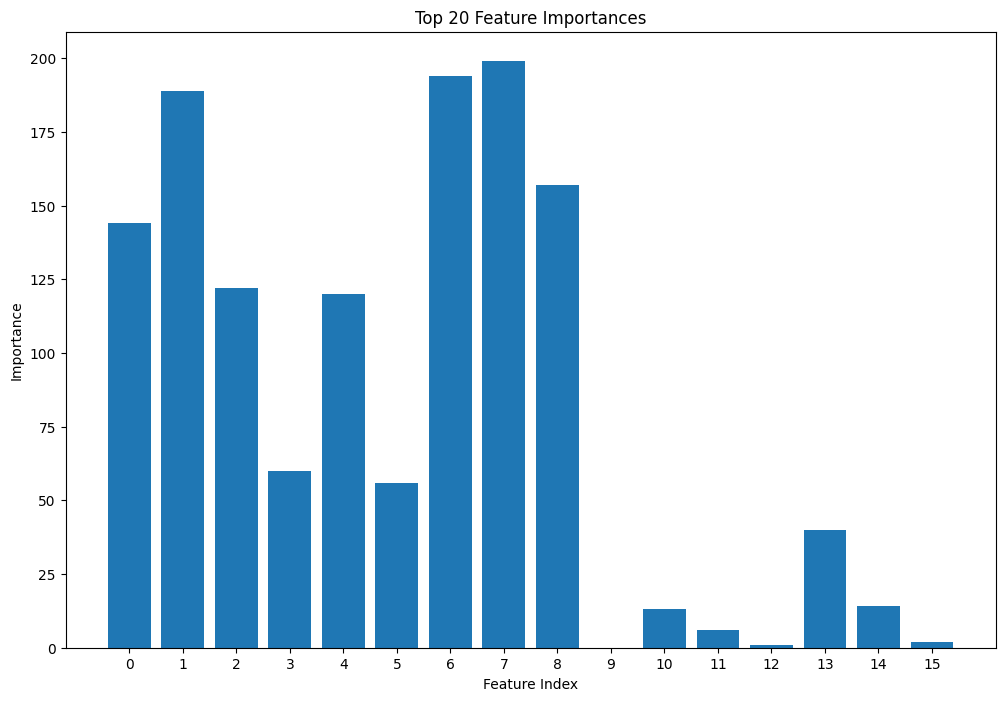

In [17]:
# Load the trained model
import pickle

model_path = os.path.join("trained_model_outputs_path", "target_classification_lgbm.pkl")
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    
    # Get feature importances
    feature_importance = model.feature_importance()
    
    # Map feature indices to feature names
    feature_indices = list(range(len(feature_importance)))
    
    # Create a dataframe of feature importances
    importance_df = pd.DataFrame({
        'feature_idx': feature_indices,
        'importance': feature_importance
    })
    importance_df = importance_df.sort_values('importance', ascending=False)
    
    # Display feature importances
    print("Feature importances:")
    display(importance_df.head(10))
    
    # Visualize feature importances
    plt.figure(figsize=(12, 8))
    plt.bar(importance_df['feature_idx'].head(20), importance_df['importance'].head(20))
    plt.xlabel('Feature Index')
    plt.ylabel('Importance')
    plt.title('Top 20 Feature Importances')
    plt.xticks(importance_df['feature_idx'].head(20))
    plt.show()
else:
    print(f"Model file not found at: {model_path}")